<a href="https://colab.research.google.com/github/hoanqphann/DataAnalyst/blob/main/Bitly_Data_from_1_USA_gov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PHÂN TÍCH DỮ LIỆU thông tin truy cập URL rút gọn (short URL)**

##**1.Định nghĩa vấn đề**
+ **Mô tả**:
   + Phạm vi: Dữ liệu gồm các bản ghi truy cập (click logs) được thu thập từ các liên kết rút gọn trên nền tảng bit.ly / 1.usa.gov.
   + Đặc điểm: Bao gồm hàng nghìn bản ghi (mẫu), mỗi bản ghi là một đối tượng JSON chứa thông tin chi tiết của một sự kiện click.
+ **Dữ liệu vào**:
   + a: Chuỗi User-Agent – thông tin về trình duyệt, hệ điều hành hoặc ứng dụng người dùng. (Object)
   + al: Ngôn ngữ người dùng (accept-language). (Object)
   + c: Mã quốc gia (ISO). (Object)
   + cy: Thành phố người truy cập (Object)
   + gr: Bang hoặc tỉnh. (Object)
   + ll: Tọa độ địa lý . (Object)
   + tz: Múi giờ của người dùng (Object)
   + nk: Số lượng click (thường là 0 hoặc 1). (float64)
   + g: mã rút gọn toàn cục của liên kết Bitly. (Object)
   + h: mã rút gọn riêng do người dùng cụ thể tạo ra. (Object)
   + l: tên tài khoản (username) của người dùng Bitly đã tạo link. (Object)
   + hh: domain rút gọn mà liên kết thuộc về. (Object)
   + r: Referrer – nguồn truy cập (Facebook, Twitter, direct,...). (Object)
   + u: URL gốc (đích đến thật). (Object)
   + t: Thời gian click (Unix timestamp). (float64)
   + hc: Thời gian tạo link rút gọn (float64)
   + kw: Từ khóa (nếu có).(Object)
   + heartbeat: Bản ghi kỹ thuật của hệ thống (dùng theo dõi trạng thái).(float64)
+ **Mục tiêu**:
   + Phân tích số lượng người dùng truy cập ở những múi giờ khác nhau.
   + Phân tích số lượng app/website truy cập vào bit.ly.
   + Phân tích số lượng truy cập theo từng múi giờ, được phân loại theo hệ điều hành.

##**2.Chuẩn bị vấn đề**

###**2.1.Khai báo thư viện**

In [ ]:
from numpy.random import randn
import numpy as np
np.random.seed(123)
import os
import matplotlib.pyplot as plt
import pandas as pd
plt.rc("figure", figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80

###**2.2.Nạp dữ liệu**

In [ ]:
path = "example.txt"
import json
path = "example.txt"
with open(path) as f:
    records = [json.loads(line) for line in f]
time_zones = [rec["tz"] for rec in records if "tz" in rec]

##**3.Mô tả thống kê**

#### **3.1.Hiển thị một số thông tin về dữ liệu**

In [ ]:
frame = pd.DataFrame(records)

In [ ]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

**Thông tin cơ bản của bộ dữ liêu**
*   Dữ liệu có 18 tính chất (cột) để phân tích, bao gồm: a, c, nk, tz, gr, g, h, l, al, hh, r, u, t, hc, cy, ll, heartbeat, kw
*   Các giá trị thuộc đa số thuộc kiểu object (chuỗi/text), 4 kiểu (float64).
*   Tổng số dòng dữ liệu là 3560 bản ghi (tổng số lần click).


In [ ]:
from collections import Counter
counts = Counter(time_zones)
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

**Dữ liệu ở trên là top 10 múi giờ truy cập nhiều nhất .Ở dòng thứ 2 bị trống là do không thể ghi nhận được múi giờ.**

#### **3.2. Xử lí dữ liệu bị trống**

In [ ]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts
counts = get_counts(time_zones)
len(time_zones)

3440

**Dựa vào dữ liệu trên có thể thấy có tất cả 3440 dữ liệu có ghi được múi giờ.**

In [ ]:
tz_counts = frame["tz"].value_counts()
tz_counts.head()


,count
tz,
America/New_York,1251
,521
America/Chicago,400
America/Los_Angeles,382
America/Denver,191


**Dòng thứ 2 có 521 dữ liệu bị trống phần múi giờ**

In [ ]:
clean_tz = frame["tz"].fillna("Missing")
clean_tz[clean_tz == ""] = "Unknown"
tz_counts = clean_tz.value_counts()
tz_counts.head()

,count
tz,
America/New_York,1251
Unknown,521
America/Chicago,400
America/Los_Angeles,382
America/Denver,191


**Cách xử lí là những nơi không biết múi giờ sẽ để thành "unknown".**

##**4.EDA và trực quan hóa dữ liệu**

###**4.1.Phân tích đơn biến(Univariate Analysis)**

***Câu hỏi 1:*** Múi giờ nào có số lượt truy cập cao nhất trong dữ liệu? Các múi giờ khác có mức độ truy cập ra sao?

<Axes: ylabel='tz'>

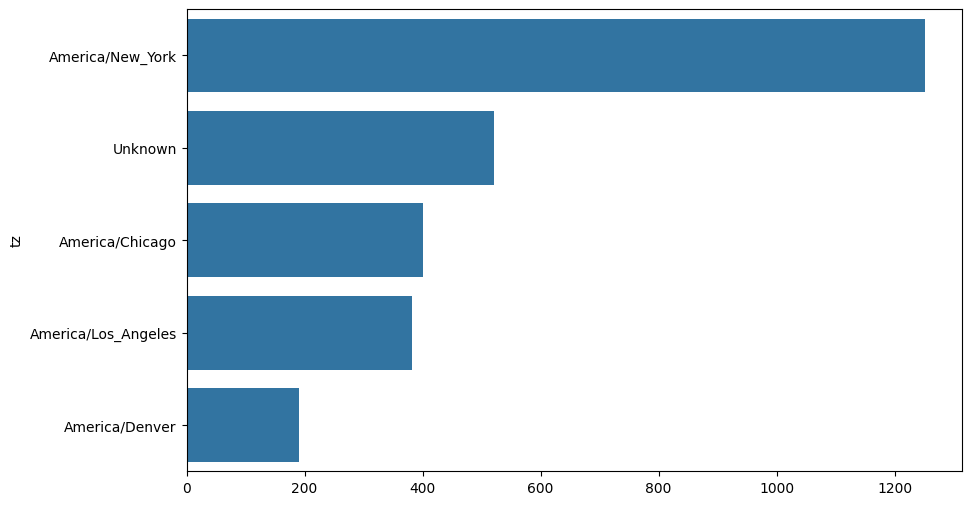

In [ ]:
import seaborn as sns
subset = tz_counts.head()
sns.barplot(y=subset.index, x=subset.to_numpy())

**Kết quả phân tích:**
  + America/New_York có số lượt truy cập cao nhất, với khoảng 1250 click.
  + America/Chicago (khoảng 400 click) và America/Los_Angeles (khoảng 300 click) theo sau.
  + Các múi giờ ở châu Âu (Europe/London) và Thái Bình Dương (Pacific/Honolulu) có lượng truy cập thấp hơn nhiều.

**Nhận xét:**
  + Người dùng ở miền Đông Hoa Kỳ (EST) chiếm phần lớn lưu lượng truy cập. Điều này hợp lý vì đây là khu vực dân cư đông, bao gồm New York, Washington D.C., Philadelphia…
  + Dữ liệu thể hiện rõ mức độ tập trung người dùng ở Bắc Mỹ, đặc biệt là Hoa Kỳ.
  + Rất ít người truy cập từ múi giờ ngoài nước Mỹ.
  


***Câu hỏi 2:*** Trình duyệt / ứng dụng nào được sử dụng nhiều nhất để truy cập các link Bitly? Điều này giúp ích gì cho nhà phân tích / doanh nghiệp?

In [ ]:
results = pd.Series([x.split()[0] for x in frame["a"].dropna()])
results.head(5)
results.value_counts().head(8)

,count
Mozilla/5.0,2594
Mozilla/4.0,601
GoogleMaps/RochesterNY,121
Opera/9.80,34
TEST_INTERNET_AGENT,24
GoogleProducer,21
Mozilla/6.0,5
BlackBerry8520/5.0.0.681,4


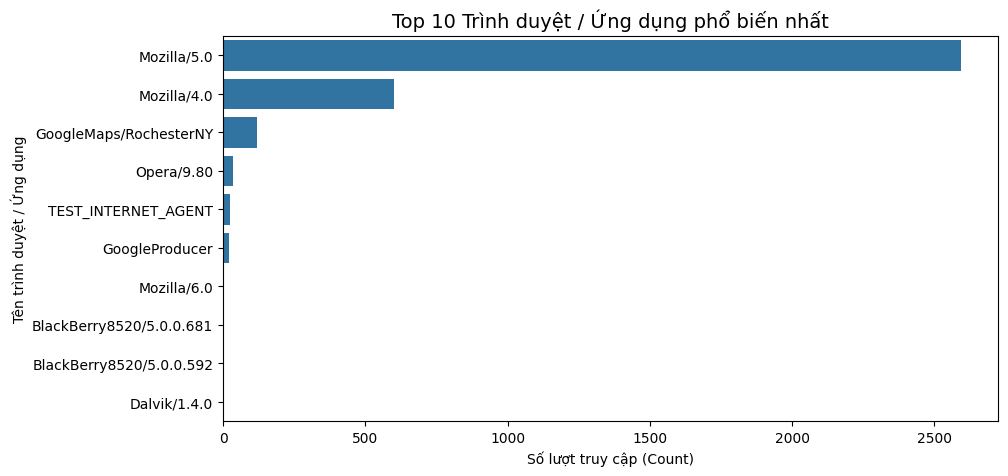

In [ ]:
frame["a"][1]
frame["a"][50]
frame["a"][51][:50]
results = pd.Series([x.split()[0] for x in frame["a"].dropna()])
browser_counts = results.value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=browser_counts.index, x=browser_counts.values)
plt.title("Top 10 Trình duyệt / Ứng dụng phổ biến nhất", fontsize=14)
plt.xlabel("Số lượt truy cập (Count)")
plt.ylabel("Tên trình duyệt / Ứng dụng")
plt.show()

**Kết quả phân tích:**
  + Biểu đồ trên thể hiện 10 trình duyệt và ứng dụng được sử dụng nhiều nhất để truy cập các đường dẫn rút gọn của Bitly. Kết quả cho thấy Mozilla/5.0 chiếm tỷ lệ vượt trội, với số lượt truy cập cao gấp nhiều lần so với các nhóm còn lại. Điều này phản ánh rằng phần lớn người dùng Bitly truy cập thông qua các trình duyệt web hiện đại (như Chrome, Firefox, Safari, Edge…), bởi hầu hết các trình duyệt này đều khai báo chuỗi nhận dạng bắt đầu bằng "Mozilla/5.0" trong user-agent.
  + Dựa vào biểu đồ và số liệu ở trên các nhà phân tích / doanh nghiệp biết được nền tảng truy cập phổ biến nhất từ đó giúp tối ưu trải nghiệm người dùng (UX). Nếu phần lớn người dùng đến từ “Mozilla/5.0” (trình duyệt hiện đại), ta có thể ưu tiên hỗ trợ các trình duyệt đó.


###**4.2.Phân tích đa biến(Multivariate Analysis)**

In [ ]:
cframe = frame[frame["a"].notna()].copy()

**Dòng lệnh ở trên để làm sạch dữ liệu (data cleaning).**

In [ ]:
cframe["os"] = np.where(cframe["a"].str.contains("Windows"),
                        "Windows", "Not Windows")
cframe["os"].head(5)

,os
0,Windows
1,Not Windows
2,Windows
3,Not Windows
4,Windows


**Phân loại trong quá trình phân tích dữ liệu Bitly click logs,
dựa trên chuỗi user agent (a) để xác định người dùng đang dùng Windows hay hệ điều hành khác.**

In [ ]:
by_tz_os = cframe.groupby(["tz", "os"])
agg_counts = by_tz_os.size().unstack().fillna(0)
agg_counts.head()

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0


**Tổng hợp dữ liệu trong phân tích dataset Bitly (example.txt).
Câu lệnh này tạo ra bảng đếm số người dùng (clicks) theo múi giờ (tz) và hệ điều hành (os).**

In [ ]:
indexer = agg_counts.sum("columns").argsort()
indexer.values[:10]

array([ 2,  7,  5,  4, 14, 11,  9,  8, 24, 26])

**xác định thứ tự (sắp xếp) các múi giờ (tz) trong bảng agg_counts theo tổng số lượt truy cập (Windows + Non-Windows).**

In [ ]:
count_subset = agg_counts.take(indexer[-10:])
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


**Dòng code trên chọn ra top 10 múi giờ (tz) có số lượt truy cập cao nhất trong dữ liệu Bitly.**

In [ ]:
agg_counts.sum(axis="columns").nlargest(10)

,0
tz,
America/New_York,1251.0
,521.0
America/Chicago,400.0
America/Los_Angeles,382.0
America/Denver,191.0
Europe/London,74.0
Asia/Tokyo,37.0
Pacific/Honolulu,36.0
Europe/Madrid,35.0


**Dòng code trên sắp xếp top 10 múi giờ có tổng lượt truy cập cao nhất (Windows + Non-Windows).**

**Câu hỏi 3:** Múi giờ nào có lượng truy cập (click) cao nhất? Người dùng hệ điều hành nào chiếm ưu thế trong từng múi giờ? Có sự khác biệt rõ rệt giữa người dùng Windows và Not Windows không?

In [ ]:
plt.figure()

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='total', ylabel='tz'>

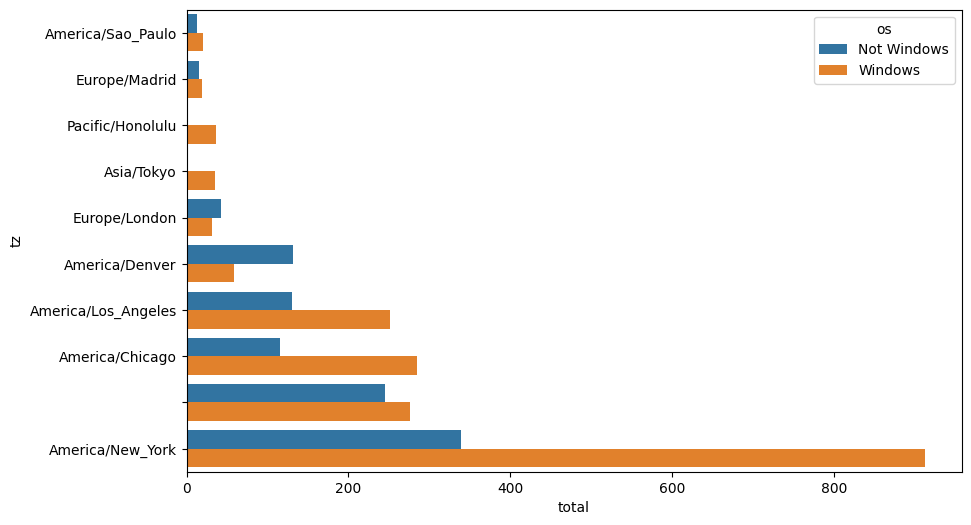

In [ ]:
count_subset = count_subset.stack()
count_subset.name = "total"
count_subset = count_subset.reset_index()
count_subset.head(10)
sns.barplot(x="total", y="tz", hue="os",  data=count_subset)

**Phân tích & Trả lời:**
1. Múi giờ hoạt động mạnh nhất:

    + Biểu đồ cho thấy America/New_York là múi giờ có tổng số lượt truy cập cao nhất, tiếp theo là America/Chicago và America/Los_Angeles.
    + Điều này phù hợp vì đây là các vùng thời gian lớn ở Hoa Kỳ – thị trường chính của Bitly.
2. So sánh hệ điều hành:
    + Trong hầu hết các múi giờ, người dùng Not Windows (Mac, Linux, iPhone, Android, v.v.)có xu hướng chiếm tỷ lệ cao hơn so với người dùng Windows.
    + Điều này cho thấy Bitly được sử dụng phổ biến trên thiết bị di động hoặc hệ điều hành khác ngoài Windows.
3. Phân bố địa lý - hành vi:
    + Các múi giờ thuộc Bắc Mỹ có hoạt động mạnh mẽ nhất,
phản ánh Bitly là nền tảng phổ biến tại Hoa Kỳ.
    + Các múi giờ khác (như châu Âu, châu Á) xuất hiện ít hơn, cho thấy phạm vi người dùng toàn cầu nhưng không đồng đều.


  -> Biểu đồ cho thấy phần lớn lượt truy cập Bitly tập trung tại các múi giờ của Hoa Kỳ, đặc biệt là America/New_York, Chicago và Los_Angeles. Trong đó, nhóm người dùng Not Windows (tức người dùng Mac, iPhone, Android, Linux,...) chiếm ưu thế rõ rệt so với Windows. Kết quả này phản ánh xu hướng người dùng Internet hiện đại sử dụng nhiều thiết bị di động và hệ điều hành đa dạng, đồng thời khẳng định Bitly là nền tảng phổ biến mạnh nhất tại khu vực Bắc Mỹ.

In [ ]:
def norm_total(group):
    group["normed_total"] = group["total"] / group["total"].sum()
    return group

results = count_subset.groupby("tz").apply(norm_total)

/tmp/ipython-input-1595230757.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = count_subset.groupby("tz").apply(norm_total)


**Dòng lệnh chuẩn hóa dữ liệu (normalize) để so sánh tỷ lệ tương đối.**

**Câu hỏi 4:** Múi giờ nào có tỷ lệ người dùng cao nhất trong toàn bộ hệ thống Bitly? Sau khi chuẩn hóa thì liệu tỉ lệ người dùng trên windows và not windows liệu có thay đổi không? Xu hướng phân bố hệ điều hành theo khu vực địa lý có gì đặc biệt?

In [ ]:
plt.figure()

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='normed_total', ylabel='tz'>

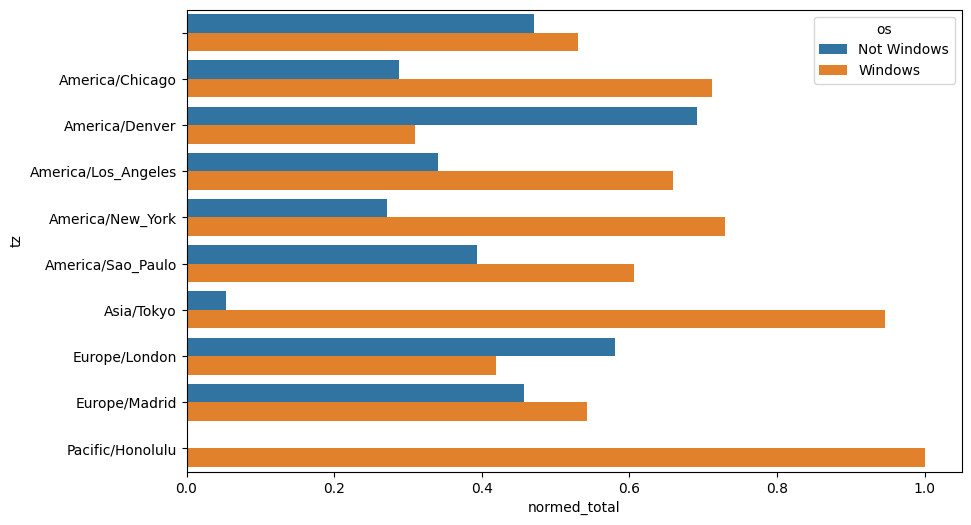

In [ ]:
sns.barplot(x="normed_total", y="tz", hue="os",  data=results)

**Phân tích & Trả lời:**
1. Về tỷ lệ tổng thể::

    + Biểu đồ cho thấy America/New_York có tỷ lệ người dùng cao nhất trong toàn bộ dữ liệu — đây là múi giờ hoạt động mạnh nhất.
    + Các múi giờ tiếp theo như America/Chicago và America/Los_Angeles cũng có tỷ lệ đáng kể, phản ánh mức độ phổ biến của Bitly tại Bắc Mỹ.
2. So sánh hệ điều hành:
    + Trong phần lớn các múi giờ, người dùng Windows chiếm tỷ lệ cao hơn người không dùng Windows. Thể hiện rõ ràng nhất ở Asia/Tokyo và Pacific/Honolulu
    + Điều này cho thấy Bitly được sử dụng phổ biến trên thiết bị Windows.
3. Phân bố địa lý - hành vi:
    + Các múi giờ thuộc Bắc Mỹ và châu Á có sự chênh lệch rõ rệt về tỷ lệ Not Windows cao.
    + Trong khi đó, một số múi giờ khác có xu hướng cân bằng hơn giữa hai nhóm người dùng.


  -> Biểu đồ thể hiện rằng phần lớn hoạt động của người dùng Bitly tập trung tại các múi giờ thuộc Hoa Kỳ, đặc biệt là America/New_York. Sau khi chuẩn hóa, ta nhận thấy nhóm người dùng Not Windows chiếm ưu thế trong hầu hết các múi giờ, phản ánh xu hướng người dùng truy cập từ các thiết bị di động và hệ điều hành khác ngoài Windows. Kết quả này cho thấy Bitly có lượng người dùng đa dạng, trải rộng theo địa lý và nền tảng công nghệ.

##**5.Kết luận**

Qua quá trình phân tích tập dữ liệu log truy cập từ hệ thống rút gọn liên kết (1.usa.gov), ta rút ra được một số kết luận chính như sau::
  + **Đặc điểm người dùng và khu vực truy cập:** hần lớn người truy cập đến từ Hoa Kỳ, chiếm tỷ lệ cao nhất trong toàn bộ dữ liệu. Bên cạnh đó còn có người dùng từ nhiều quốc gia khác nhau cho thấy tính toàn cầu của hệ thống chia sẻ liên kết này.
  + **Thiết bị và trình duyệt sử dụng:** Người dùng chủ yếu sử dụng trình duyệt Chrome và Firefox trên máy tính, ngoài ra có một lượng đáng kể từ thiết bị di động như iPhone, iPad, Android, BlackBerry. Xu hướng truy cập qua thiết bị di động bắt đầu tăng lên rõ rệt
  + **số lượng truy cập theo từng múi giờ, được phân loại theo hệ điều hành:** Số lượng truy cập tập trung chủ yếu ở múi giờ Hoa Kỳ, đặc biệt là “America/New_York”. Hệ điều hành phổ biến nhất là Windows, tiếp theo là Mac OS và iOS. Người dùng tại châu Mỹ truy cập chủ yếu bằng máy tính, trong khi người dùng châu Á và châu Âu có xu hướng truy cập bằng thiết bị di động.
  + **Tương quan giữa múi giờ và hệ điều hành:** Ở các múi giờ Mỹ (America/New_York, America/Los_Angeles), Windows và Mac OS chiếm ưu thế. Ở các múi giờ Châu Á và Châu Âu, tỷ lệ iOS và Android cao hơn, do người dùng ở đây thường truy cập qua thiết bị di động.Kết quả này gợi ý rằng người dùng ở khu vực khác nhau có thói quen và thiết bị truy cập khác biệt rõ rệt.  

